**Author Information**
* Barry Li: 
    * 260912069
    * weien.li@mail.mcgill.ca
* Minzhe Feng: 
    * 260886087
    * minzhe.feng@mail.mcgill.ca

[Colab Link for this Notebook](https://colab.research.google.com/drive/1sV3jljSrtmjilOtplhmDFIjEdt1OumwF?usp=sharing)

In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression

# Report

**Environment Setup:**  
The same cart pole environment that we used in Assignment 2. We also applied the same discretization treatment as last time by splitting each of the four continuous variables into 10 bins to conduct tabular RL.

\\
**Preferred Expert Agent:**  
We used the linear function approximation with softmax policy from Assignment 2.

\\
**Imitation Learning Setup:**  
We used standard logistic regression, which accepts a 4-tuple describing the current state and outputs the action with the highest predicted value.

\\
**Fitted Q-Learning Setup:**  
We implemented the fitted Q-learning agent as described in the assignment and employed full-batch gradient descent. We stopped training each batch of data when the error fell below a pre-determined threshold $\epsilon$ (1e-4 in this experiment) or after 100 rounds of gradient descent when the error hadn't converged.

\\
**Learning Rate Choice**:  
We settled on $\alpha=1/6$ for our expert agent and $\alpha=0.015$ for our fitted Q-learning agent, as this pair produced the best results among all the value combinations we tried.

\\
**Experiment Steps:**  
We gathered 500 episodes of experience data using the expert policy and another uniformly random policy (where the action taken at each step was drawn from a uniform distribution) while training the expert agent. Preliminary analysis (the plots under the first two sections below) showed that the expert policy had a much longer average episode length than the random policy, as expected.

After collecting the dataset, we then created 9 training sets of size 100, 250 & 500. For each size, we have three different variations where:
* All episodes are from the expert policy
* All episodes are from the random policy
* Half were from each policy (referred to as "half-half" from now on)

At last, we trained the imitation and fitted Q-learning agent on these 9 training sets with 15 epochs each and recorded & plotted the average return for each configuration.

**Results & Conclusions**  
From the last bar plots, we can see that:
* The all-random training sets consistently had the worst performance than the other two variations, as expected. However, the half-half variation displayed surprisingly strong results that were generally on par with those from the all-expert variation.
* The only configuration whose performance was noticeably influenced by the size of the dataset was half-half+fitted Q-learning. This could be because fitted Q-learning requiress more high quality expert data to train, while the imitation learning agent could already work reasonably well with just 100 (expert) episode data.
* **Most importantly**, when comparing the two agents, we observed that imitation learning performed visibly better than fitted Q-learning (they were still close). This is the biggest surprise in this experiment, and the several factors may have contributed:  
    * Our fitted Q-learning implementation might have room for improvements, while the logistic regression algorithm used by the imitation agent is much simpler & has less room for error.
    * Fitted Q-learning could require more data for training that this experiment setup simply did not offer.
    * The fitted Q-learning agent can potentially stick to its training data too closely and forego exploration opportunities that might lead to better results.

# Expert Policy

In [ ]:
class Encoding:
    def __init__(self, env):
        """
        set the linspace number to 9 since 10 bins so number biggest than max will
        get bin index 9 and number smllaer than min will get bin index 0.
        """
        self.bins = [
            np.linspace(-2.4, 2.4, 9),  # cart position
            np.linspace(-3, 3, 9),  # cart velocity could be inf
            np.linspace(-0.2095, 0.2095, 9),  # pole angel
            np.linspace(-3, 3, 9),  # pole velocity could be inf
        ]
        self.obsSpaceSize = len(env.observation_space.high)

    def create_qTable(self, env):  # for the epsilon greedy policy
        
        qTable = np.random.uniform(
            low=-0.001, high=0.001, size=([10] * self.obsSpaceSize) + [env.action_space.n]
        )
        return qTable

    def create_weighttable(self):  # for linear weight approximation
        np.random.seed(578)
        wtable = np.random.uniform(
            low=-0.001, high=0.001, size=([10] * self.obsSpaceSize)
        )
        return wtable

    def get_discrete_state(self, state):
        stateIndex = []
        for i in range(self.obsSpaceSize):
            stateIndex.append(np.digitize(state[i], self.bins[i]))
        return tuple(stateIndex)

In [ ]:
class LinearFunctionApproximation:
    def __init__(self, encoder: Encoding, Lr: float):
        self.wtable = encoder.create_weighttable()
        self.alpha_w = Lr

    # evaluate the state using linear approximation
    def evaluate(self, state):  # state is discrete state encoded
        return self.wtable[state]

    def update(self, state, small_delta):  # state is discrete state encoded
        self.wtable[state] += self.alpha_w * small_delta

In [ ]:
class Softmax_Policy:  # Softmax Policy for Actor Crtic
    def __init__(self, encoder: Encoding, Lr: float, temprature: int, env):
        self.thetaTable = encoder.create_qTable(env)
        self.alpha_theta = Lr
        self.temprature = temprature

    def pi(self, state):
        thetas = self.thetaTable[state]
        numerator = np.exp(thetas / self.temprature)
        denom = np.sum(numerator)
        return numerator / denom

    def policy(self, state):
        ps = self.pi(state)
        return np.random.choice(range(2), p=ps)

    def update(self, state, action, factor):  # factor should be I * delta
        probvec = self.pi(state)
        x_s = np.zeros(2)
        x_s[action] = 1
        gradient = x_s - probvec
        self.thetaTable[state] += self.alpha_theta * gradient * factor

In [ ]:
# Training
alpha = 1 / 6
temprature = 2
GAMMA = 0.95


def Expert():
    seed = 579
    env = gym.make("CartPole-v1")
    e1 = Encoding(env)
    np.random.seed(seed)
    Policy = Softmax_Policy(e1, alpha, temprature, env)
    LFA = LinearFunctionApproximation(e1, alpha)

    for episode in range(700):
        I = 1
        state = env.reset()[0]
        discrete_state = e1.get_discrete_state(state)
        R_sum_episode = 0
        while True:
            action = Policy.policy(discrete_state)
            state_next, reward, done, timeout, _ = env.step(action)
            discrete_state_next = e1.get_discrete_state(state_next)
            target = (
                reward + GAMMA * LFA.evaluate(discrete_state_next)
                if not (done or timeout)
                else reward
            )
            delta = target - LFA.evaluate(discrete_state)
            LFA.update(discrete_state, delta)
            Policy.update(discrete_state, action, I * delta)
            I *= GAMMA
            discrete_state = discrete_state_next
            if done or timeout:
                break
    return Policy

In [ ]:
def ExpertData(Policy):
    seed = 579
    env = gym.make("CartPole-v1")
    e1 = Encoding(env)
    np.random.seed(seed)
    data = []
    for episode in range(500):
        state = env.reset()[0]
        discrete_state = e1.get_discrete_state(state)
        episo_data = []
        while True:
            action = Policy.policy(discrete_state)
            state_next, reward, done, timeout, _ = env.step(action)
            discrete_state_next = e1.get_discrete_state(state_next)
            step_data = [discrete_state, action, reward, discrete_state_next]
            episo_data.append(step_data)
            discrete_state = discrete_state_next
            if done or timeout:
                break
        data.append(episo_data)
    return data


In [ ]:
ExpertPolicy = Expert()
expert_data = ExpertData(ExpertPolicy)
np_expert = np.array(expert_data, dtype=object)
np_expert.shape

(500,)

In [ ]:
p = []
counts = 0
for i in range(500):
    p.append(len(np_expert[i]))
    counts += len(np_expert[i])
print(counts)

73820


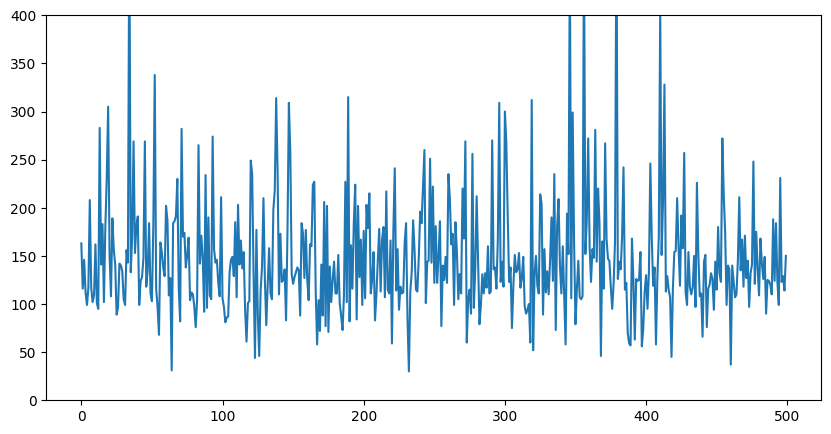

In [ ]:
xaxis = np.arange(500)
plt.figure(figsize=(10, 5))
plt.ylim(0, 400)
plt.plot(xaxis, p)
plt.show()

# Random Policy

In [ ]:
def Random():
    seed = 579
    env = gym.make("CartPole-v1")
    e1 = Encoding(env)
    random.seed(579)
    data = []
    for episode in range(500):
        state = env.reset()[0]
        discrete_state = e1.get_discrete_state(state)
        episo_data = []
        while True:
            action = random.choices(population=[1, 0], weights=[0.5, 0.5], k=1)[0]
            state_next, reward, done, timeout, _ = env.step(action)
            discrete_state_next = e1.get_discrete_state(state_next)

            step_data = [discrete_state, action, reward, discrete_state_next]
            episo_data.append(step_data)

            discrete_state = discrete_state_next
            if done or timeout:
                break
        data.append(episo_data)
    return data

In [ ]:
Random_data = Random()
np_Random = np.array(Random_data, dtype=object)
np_Random.shape

(500,)

In [ ]:
count = 0
pp = []
for i in range(500):
    pp.append(len(np_Random[i]))
    count += len(np_Random[i])

In [ ]:
count

10980

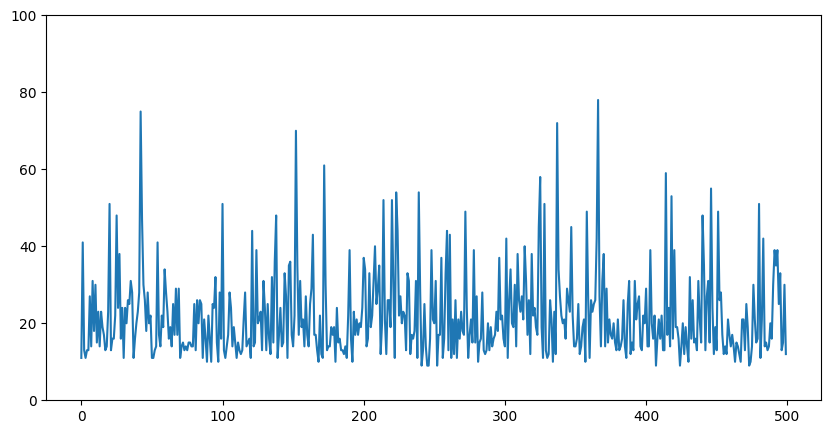

In [ ]:
xaxis = np.arange(500)
plt.figure(figsize=(10, 5))
plt.ylim(0, 100)
plt.plot(xaxis, pp)
plt.show()

# Imitation Learning

In [ ]:
class Imitation_Model:
    def __init__(self):
        self.model = LogisticRegression(random_state=0)

    def learn(self, raw_data):
        learn_states = np.empty([0, 4])
        learn_labels = np.empty(0, dtype=np.int64)
        for epi in raw_data:
            np_epi = np.array(epi, dtype=object)
            arr = np_epi[:, 0]
            states = map(np.array, arr)
            states = np.array(list(states))
            learn_states = np.concatenate((learn_states, states), axis=0)
            label = np_epi[:, 1]
            np_label = np.asarray(label, dtype=np.int64)
            learn_labels = np.concatenate((learn_labels, np_label), axis=None)
        self.model.fit(learn_states, learn_labels)

In [ ]:
# model1 = Imitation_Model()
# model1.learn(np_expert)

In [ ]:
# model1.model.coef_

In [ ]:
# model1.model.predict_proba([[2, 7, 7, 7]])

# Fitted Q-Learning

In [ ]:
class FittedQLearning:
    def __init__(self, encoder, env, alpha, K, iterations, epsilon=1e-4, gamma=0.95):
        self.qTable = encoder.create_qTable(env)
        self.alpha = alpha
        self.batch_size = K
        self.iterations = iterations
        self.gamma = gamma
        self.epsilon = epsilon

    def fit(self, prep):
        states = prep[:, 0]
        actions = prep[:, 1]
        rewards = prep[:, 2]
        next_states = prep[:, 3]
        np.random.seed(579)
        for i in range(self.iterations):  # epoch
            indices = np.arange(len(prep))
            sampled = []
            notfinished = True
            while notfinished:
                remaining = np.setdiff1d(indices, sampled)
                if len(remaining) <= self.batch_size:
                    notfinished = False
                    idx = remaining
                else:
                    idx = np.random.choice(remaining, size=self.batch_size, replace=False)
                states_batch = states[idx]
                actions_batch = actions[idx].astype(int)
                rewards_batch = rewards[idx].astype(np.float64)
                next_states_batch = next_states[idx]
                sampled += list(idx)
                next_Qs = np.amax(
                    np.array([self.qTable[i] for i in next_states_batch]), axis=1
                )
                target_Qs = rewards_batch + self.gamma * next_Qs
                iter = 0
                while iter <= 100:  # To prevent the agorithm from getting stuck
                    predicted_Qs = np.array(
                        [
                            self.qTable[states_batch[i]][actions_batch[i]]
                            for i in range(len(idx))
                        ]
                    )
                    mse = (np.square(predicted_Qs - target_Qs)).mean(axis=None)
                    if (
                        mse <= self.epsilon
                    ):  # if mse now smaller than epsilon we go to next batch
                        # print(f"Final MSE = {mse}")
                        break
                    dim0 = [x[0] for x in states_batch]
                    dim1 = [x[1] for x in states_batch]
                    dim2 = [x[2] for x in states_batch]
                    dim3 = [x[3] for x in states_batch]
                    updated = self.qTable[
                        dim0, dim1, dim2, dim3, actions_batch
                    ] + self.alpha * (target_Qs - predicted_Qs)
                    self.qTable[dim0, dim1, dim2, dim3, actions_batch] = updated
                    iter += 1



    def actions(self, state):
        return np.argmax(self.qTable[state])

In [ ]:
def preprocess(dataset):
    unstacked = [entry for eps in dataset for entry in eps]
    return np.array(unstacked, dtype=object)

In [ ]:
# Testing
# env = gym.make("CartPole-v1")
# e1 = Encoding(env)
# prep = preprocess(np_expert)
# prep.shape
# FQL = FittedQLearning(e1, env, 0.1, prep.shape[0], 10)

In [ ]:
# FQL.fit(prep)

# Train & Plot

Dataset Preparation

In [ ]:
# diff() function ensures that an episode wouldn't get drawn twice
sample = lambda data, size: np.random.choice(data, size=size, replace=False)
diff = lambda arr1, arr2: np.setdiff1d(arr1, arr2)

In [ ]:
np.random.seed(579)
random100 = sample(np_Random, 100)
expert100 = sample(np_expert, 100)
half100 = np.concatenate((sample(np_expert, 50), sample(np_Random, 50)))
random250 = np.concatenate((random100, sample(diff(np_Random, random100), 150)))
expert250 = np.concatenate((expert100, sample(diff(np_expert, expert100), 150)))
half250 = np.concatenate((half100, sample(diff(np_Random, half100), 75), sample(diff(np_expert, half100), 75)))
random500 = np.concatenate((random250, sample(diff(np_Random, random250), 250)))
expert500 = np.concatenate((expert250, sample(diff(np_expert, expert250), 250)))
half500 = np.concatenate((half250, sample(diff(np_Random, half250), 125), sample(diff(np_expert, half250), 125)))

In [ ]:
env = gym.make("CartPole-v1")
e1 = Encoding(env)
random100p = preprocess(random100)
expert100p = preprocess(expert100)
half100p = preprocess(half100)
random250p = preprocess(random250)
expert250p = preprocess(expert250)
half250p = preprocess(half250)
random500p = preprocess(random500)
expert500p = preprocess(expert500)
half500p = preprocess(half500)

**Data Analysis: Calculate Average on each dataset**

In [ ]:
avgrandom100p = len(random100p) / 100
avgrandom250p = len(random250p) / 250
avgrandom500p = len(random500p) / 500
avgexpert100p = len(expert100p) / 100
avgexpert250p = len(expert250p) / 250
avgexpert500p = len(expert500p) / 500
avghalf100p = len(half100p)/100
avghalf250p = len(half250p)/250
avghalf500p = len(half500p)/500

In [ ]:
print("Random Averages \n 100: {0} \n 250: {1} \n 500: {2}".format(avgrandom100p,avgrandom250p, avgrandom500p))
print("Expert Averages \n 100: {0} \n 250: {1} \n 500: {2}".format(avgexpert100p,avgexpert250p, avgexpert500p))
print("Half-Half Averages \n 100: {0} \n 250: {1} \n 500: {2}".format(avghalf100p,avghalf250p, avghalf500p))

Random Averages 
 100: 22.29 
 250: 21.44 
 500: 21.96
Expert Averages 
 100: 154.96 
 250: 146.732 
 500: 147.64
Half-Half Averages 
 100: 80.24 
 250: 82.324 
 500: 84.454


In [ ]:
random100imi = Imitation_Model()
random100imi.learn(random100)
expert100imi = Imitation_Model()
expert100imi.learn(expert100)
half100imi = Imitation_Model()
half100imi.learn(half100)
random250imi = Imitation_Model()
random250imi.learn(random250)
expert250imi = Imitation_Model()
expert250imi.learn(expert250)
half250imi = Imitation_Model()
half250imi.learn(half250)
random500imi = Imitation_Model()
random500imi.learn(random500)
expert500imi = Imitation_Model()
expert500imi.learn(expert500)
half500imi = Imitation_Model()
half500imi.learn(half500)

random100q = FittedQLearning(e1, env, 0.015, random100p.shape[0], 15)
random100q.fit(random100p)
expert100q = FittedQLearning(e1, env, 0.015, expert100p.shape[0], 15)
expert100q.fit(expert100p)
half100q = FittedQLearning(e1, env, 0.015, half100p.shape[0], 15)
half100q.fit(half100p)
random250q = FittedQLearning(e1, env, 0.015, random250p.shape[0], 15)
random250q.fit(random250p)
expert250q = FittedQLearning(e1, env, 0.015, expert250p.shape[0], 15)
expert250q.fit(expert250p)
half250q = FittedQLearning(e1, env, 0.015, half250p.shape[0], 15)
half250q.fit(half250p)
random500q = FittedQLearning(e1, env, 0.015, random500p.shape[0], 15)
random500q.fit(random500p)
expert500q = FittedQLearning(e1, env, 0.015, expert500p.shape[0], 15)
expert500q.fit(expert500p)
half500q = FittedQLearning(e1, env, 0.015, half500p.shape[0], 15)
half500q.fit(half500p)

In [ ]:
def q_reward(agent):
    env = gym.make("CartPole-v1")
    e1 = Encoding(env)
    np.random.seed(579)
    rewards = []
    for episode in range(100):
        state = env.reset()[0]
        discrete_state = e1.get_discrete_state(state)
        rw = 0
        while True:
            action = np.argmax(agent.qTable[discrete_state[0], discrete_state[1], 
                                            discrete_state[2], discrete_state[3]])
            state_next, reward, done, timeout, _ = env.step(action)
            discrete_state_next = e1.get_discrete_state(state_next)
            rw += reward
            discrete_state = discrete_state_next
            if done or timeout:
                break
        rewards.append(rw)
    return np.array(rewards)

def imitation_reward(agent):
    env = gym.make("CartPole-v1")
    e1 = Encoding(env)
    np.random.seed(579)
    rewards = []
    for episode in range(100):
        state = env.reset()[0]
        discrete_state = e1.get_discrete_state(state)
        rw = 0
        while True:
            action = agent.model.predict([discrete_state])[0]
            state_next, reward, done, timeout, _ = env.step(action)
            discrete_state_next = e1.get_discrete_state(state_next)
            rw += reward
            discrete_state = discrete_state_next
            if done or timeout:
                break
        rewards.append(rw)
    return np.array(rewards)

Testing

In [ ]:
# expert500q = FittedQLearning(e1, env, 0.015, expert500p.shape[0], 15)
# expert500q.fit(expert500p)
# expert500q_reward = q_reward(expert500q)

In [ ]:
# expert500q_reward

End of Testing

In [ ]:
random100imi_reward = imitation_reward(random100imi)
expert100imi_reward = imitation_reward(expert100imi)
half100imi_reward = imitation_reward(half100imi)
random250imi_reward = imitation_reward(random250imi)
expert250imi_reward = imitation_reward(expert250imi)
half250imi_reward = imitation_reward(half250imi)
random500imi_reward = imitation_reward(random500imi)
expert500imi_reward = imitation_reward(expert500imi)
half500imi_reward = imitation_reward(half500imi)

random100q_reward = q_reward(random100q)
expert100q_reward = q_reward(expert100q)
half100q_reward = q_reward(half100q)
random250q_reward = q_reward(random250q)
expert250q_reward = q_reward(expert250q)
half250q_reward = q_reward(half250q)
random500q_reward = q_reward(random500q)
expert500q_reward = q_reward(expert500q)
half500q_reward = q_reward(half500q)


**The red, green & blue horizontal lines in each of the three plots below correspond to average returns of the expert, random and half-half policies respectively.**

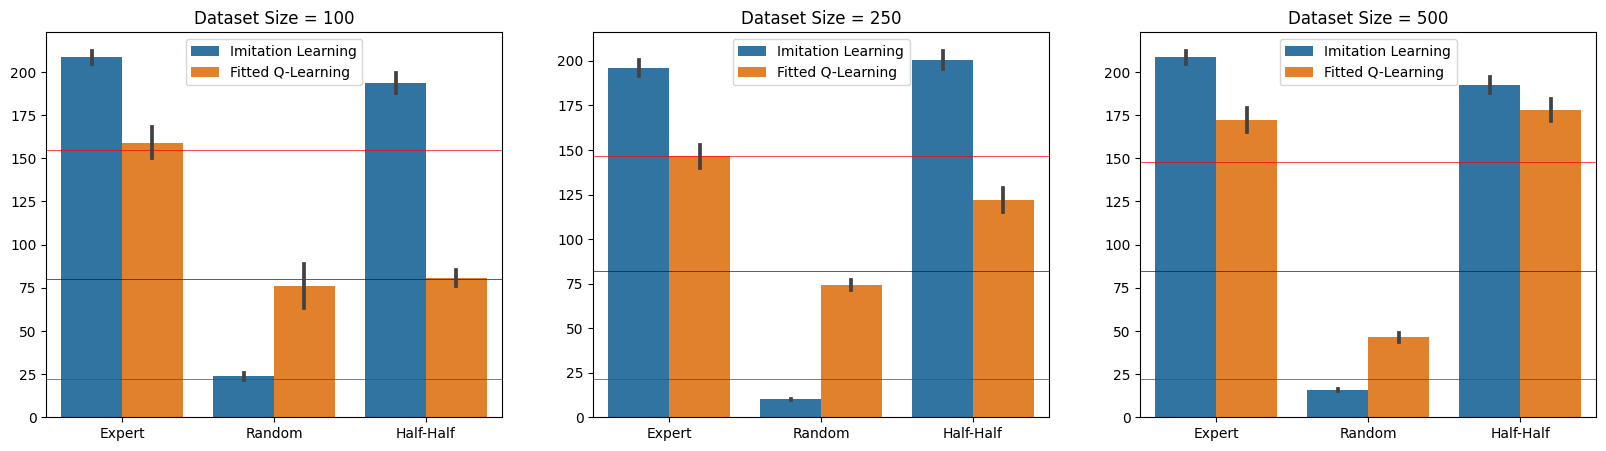

In [ ]:
avg_calc = lambda x: sum([len(y) for y in x]) / len(x)
figs, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, data in enumerate(([expert100imi_reward, expert100q_reward, random100imi_reward, 
                           random100q_reward, half100imi_reward, half100q_reward, 
                           expert100, random100, half100],
                          [expert250imi_reward, expert250q_reward, random250imi_reward, 
                           random250q_reward, half250imi_reward, half250q_reward, 
                           expert250, random250, half250],
                          [expert100imi_reward, expert500q_reward, random500imi_reward, 
                           random500q_reward, half500imi_reward, half500q_reward, 
                           expert500, random500, half500])):
    axes[i].set_title(f"Dataset Size = {(100, 250, 500)[i]}")
    raw = {'x': ["Expert"] * 200 + ["Random"] * 200 + ["Half-Half"] * 200,
           'y': (lambda x: list(x[0]) + list(x[1]) + list(x[2]) + list(x[3]) +
                 list(x[4]) + list(x[5]))(data),
           'category': (["Imitation Learning"] * 100 + ["Fitted Q-Learning"] * 100) * 3}
    avg_expert = avg_calc(data[6])
    avg_random = avg_calc(data[7])
    avg_half = avg_calc(data[8])
    axes[i].axhline(avg_expert, color='r', linewidth=0.5)
    axes[i].axhline(avg_random, color='g', linewidth=0.5)
    axes[i].axhline(avg_half, color='b', linewidth=0.5)
    sns.barplot(x='x', y='y', hue='category', data=raw, ax=axes[i], errorbar='se')

In [ ]:
expert500q_reward.mean()

172.27

# Bonus: Deep Q-Learning

We used the expert dataset of size 500 to tune the model here. Unfortunately, the result was still not ideal (i.e., low average return), but we just want to demonstrate our thought process here.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
def dq_state_convert(t):
    test = np.asarray(t)
    return test

In [ ]:
test = expert500p[:,0]
x = map(np.array, test)
x = np.array(list(x))
x.dtype

dtype('int64')

In [ ]:
indices = np.arange(100)
rewards = expert500p[:,2]
idx = np.random.choice(indices, size=20, replace=False)
rewards_batch = rewards[idx].astype(np.float64)
rewards_batch.shape

(20,)

In [ ]:
def aux(state_batch):
  x = map(np.array, state_batch)
  x = np.array(list(x))
  return x

In [ ]:
class DQNAgent:
    def __init__(self,env,batch_size,epochs):
        self.state_size = 4
        self.action_size = env.action_space.n
        self.gamma = 0.95
        self.learning_rate = 0.005
        self.model = self.build_model()
        self.batch_size = batch_size
        self.epoch = epochs

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def train(self, dataset):
        np.random.seed(579)
        states = dataset[:, 0]
        actions = dataset[:, 1]
        rewards = dataset[:, 2]
        next_states = dataset[:, 3]
        for i in range(self.epoch):
          indices = np.arange(len(dataset))
          sampled = []
          notfinished = True
          print("Epochs : {0}".format(i+1))
          while notfinished:
              remaining = np.setdiff1d(indices, sampled)
              if len(remaining) <= self.batch_size:
                  notfinished = False
                  idx = remaining
              else:
                  idx = np.random.choice(remaining, size=self.batch_size, replace=False)
              states_batch = states[idx]
              actions_batch = actions[idx].astype(int)
              rewards_batch = rewards[idx].astype(np.float64)
              next_states_batch = next_states[idx]
              sampled += list(idx)

              state_conv = aux(states_batch) #try converting states from tuple into numpy 
              next_state_conv = aux(next_states_batch)

              target_qs = self.model.predict(next_state_conv, verbose = 0)
              max_next_qs = np.amax(target_qs, axis=1)
              target_fs = self.model.predict(state_conv,verbose = 0)
              targets = rewards_batch + self.gamma * max_next_qs

              for i, action in enumerate(actions_batch):
                  target_fs[i][action] = targets[i]
              
              self.model.fit(state_conv, target_fs,batch_size=self.batch_size, epochs=1, verbose=1)
              #laps +=1
  
    def act(self,state):
        pre_state = dq_state_convert(state)
        pre_state = pre_state.reshape(1,4)
        q_val = self.model.predict(pre_state,verbose = 0)
        return np.argmax(q_val[0])

In [ ]:
env = gym.make("CartPole-v1")
with tf.device('/device:GPU:0'):
  expert500dq = DQNAgent(env,expert500p.shape[0],100)
  expert500dq.train(expert500p)

Epochs : 1
1/1 [==============================] - 1s 1s/step - loss: 1.4746
Epochs : 2
1/1 [==============================] - 0s 14ms/step - loss: 1.3229
Epochs : 3
1/1 [==============================] - 0s 13ms/step - loss: 1.2132
Epochs : 4
1/1 [==============================] - 0s 14ms/step - loss: 1.1740
Epochs : 5
1/1 [==============================] - 0s 20ms/step - loss: 1.1698
Epochs : 6
1/1 [==============================] - 0s 13ms/step - loss: 1.1769
Epochs : 7
1/1 [==============================] - 0s 13ms/step - loss: 1.2019
Epochs : 8
1/1 [==============================] - 0s 15ms/step - loss: 1.2406
Epochs : 9
1/1 [==============================] - 0s 11ms/step - loss: 1.2514
Epochs : 10
1/1 [==============================] - 0s 13ms/step - loss: 1.2523
Epochs : 11
1/1 [==============================] - 0s 16ms/step - loss: 1.2498
Epochs : 12
1/1 [==============================] - 0s 11ms/step - loss: 1.2375
Epochs : 13
1/1 [==============================] - 0s 16ms/step

In [ ]:
def dq_reward(agent):
    env = gym.make("CartPole-v1")
    e1 = Encoding(env)
    np.random.seed(579)
    rewards = []
    for episode in range(100):
        state = env.reset()[0]
        discrete_state = e1.get_discrete_state(state)
        rw = 0
        while True:
            action = agent.act(discrete_state)
            state_next, reward, done, timeout, _ = env.step(action)
            discrete_state_next = e1.get_discrete_state(state_next)
            rw += reward
            discrete_state = discrete_state_next
            if done or timeout:
                break
        rewards.append(rw)
    return np.array(rewards)

In [ ]:
with tf.device('/device:GPU:0'):
  dq_500_r = dq_reward(expert500dq)

In [ ]:
dq_500_r.mean()

9.42